In [85]:
# pip install psychopg2
import psycopg2 as ps
import numpy as np
import pandas as pd
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import folium
# import os

df = pd.read_csv('data_files/cause_of_deaths_geo.csv')
df.dropna(axis=0, how='all',thresh=4, inplace=True)
df
# print(df.head(10))
# print(df.describe(include='all'))

,Unnamed: 0,Country/Territory,Code,Year,Meningitis,Alzheimer's Disease and Other Dementias,Parkinson's Disease,Nutritional Deficiencies,Malaria,Drowning,...,Poisonings,Protein-Energy Malnutrition,Road Injuries,Chronic Respiratory Diseases,Cirrhosis and Other Chronic Liver Diseases,Digestive Diseases,"Fire, Heat, and Hot Substances",Acute Hepatitis,lat,lng
0,0,Afghanistan,AFG,1990.0,2159.0,1116.0,371.0,2087.0,93.0,1370.0,...,338.0,2054.0,4154.0,5945.0,2673.0,5005.0,323.0,2985.0,34.53313,69.10221
1,1,Afghanistan,AFG,1991.0,2218.0,1136.0,374.0,2153.0,189.0,1391.0,...,351.0,2119.0,4472.0,6050.0,2728.0,5120.0,332.0,3092.0,34.53313,69.10221
2,2,Afghanistan,AFG,1992.0,2475.0,1162.0,378.0,2441.0,239.0,1514.0,...,386.0,2404.0,5106.0,6223.0,2830.0,5335.0,360.0,3325.0,34.53313,69.10221
3,3,Afghanistan,AFG,1993.0,2812.0,1187.0,384.0,2837.0,108.0,1687.0,...,425.0,2797.0,5681.0,6445.0,2943.0,5568.0,396.0,3601.0,34.53313,69.10221
4,4,Afghanistan,AFG,1994.0,3027.0,1211.0,391.0,3081.0,211.0,1809.0,...,451.0,3038.0,6001.0,6664.0,3027.0,5739.0,420.0,3816.0,34.53313,69.10221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115,6115,Zimbabwe,ZWE,2015.0,1439.0,754.0,215.0,3019.0,2518.0,770.0,...,381.0,2990.0,2373.0,2751.0,1956.0,4202.0,632.0,146.0,-17.82440,31.04994
6116,6116,Zimbabwe,ZWE,2016.0,1457.0,767.0,219.0,3056.0,2050.0,801.0,...,393.0,3027.0,2436.0,2788.0,1962.0,4264.0,648.0,146.0,-17.82440,31.04994
6117,6117,Zimbabwe,ZWE,2017.0,1460.0,781.0,223.0,2990.0,2116.0,818.0,...,398.0,2962.0,2473.0,2818.0,2007.0,4342.0,654.0,144.0,-17.82440,31.04994
6118,6118,Zimbabwe,ZWE,2018.0,1450.0,795.0,227.0,2918.0,2088.0,825.0,...,400.0,2890.0,2509.0,2849.0,2030.0,4377.0,657.0,139.0,-17.82440,31.04994


Upload data to a AWS postgresSQL database.

In [86]:
# def connect_to_db(host_name, dbname, port, username, password):
#     try:
#         conn = ps.connect(host=host_name, database=dbname, user=username, password=password, port=port)
#     except ps.OperationalError as e:
#         raise e
#     else:
#         print('Connected!')
#     return conn

In [87]:
# host_name = 'causesdb.ck7qighb1kv8.us-east-1.rds.amazonaws.com'
# dbname = 'causesdb'
# port = '5432'
# username = 'danicaboe'
# password = os.getenv('aws_password')
# conn = connect_to_db(host_name, dbname, port, username, password)

In [88]:
# Save list of column in variable to view

print(df.columns)
# rename specific columns that have unusual charcters or redundunt naming convention or commas.
df.rename(columns= {'Country/Territory': 'country', 'Code': 'country_code', 'Protein-Energy Malnutrition': 'protein_malnutrition', 'Alzheimer\'s Disease and Other Dementias': 'dementia', 'Self-harm': 'self_harm', 'Fire, Heat, and Hot Substances': 'fire_heat', 'lat': 'latitude', 'lng': 'longitude'}, inplace=True)
# print(df.columns)
# create variable to see all the unique countries that are represented.
countries = df['country'].unique()
print(countries)
print(df.country_code.count())
# Print the number of unique countries
print(df['country'].nunique())



Index(['Unnamed: 0', 'Country/Territory', 'Code', 'Year', 'Meningitis',
       'Alzheimer's Disease and Other Dementias', 'Parkinson's Disease',
       'Nutritional Deficiencies', 'Malaria', 'Drowning',
       'Interpersonal Violence', 'Maternal Disorders', 'HIV/AIDS',
       'Drug Use Disorders', 'Tuberculosis', 'Cardiovascular Diseases',
       'Lower Respiratory Infections', 'Neonatal Disorders',
       'Alcohol Use Disorders', 'Self-harm', 'Exposure to Forces of Nature',
       'Diarrheal Diseases', 'Environmental Heat and Cold Exposure',
       'Neoplasms', 'Conflict and Terrorism', 'Diabetes Mellitus',
       'Chronic Kidney Disease', 'Poisonings', 'Protein-Energy Malnutrition',
       'Road Injuries', 'Chronic Respiratory Diseases',
       'Cirrhosis and Other Chronic Liver Diseases', 'Digestive Diseases',
       'Fire, Heat, and Hot Substances', 'Acute Hepatitis', 'lat', 'lng'],
      dtype='object')
['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antig

Edit all column names - change all to lower and replace spaces with underscores.

In [89]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
df.drop('unnamed:_0', axis=1, inplace=True)
print(df.columns)

Index(['country', 'country_code', 'year', 'meningitis', 'dementia',
       'parkinson's_disease', 'nutritional_deficiencies', 'malaria',
       'drowning', 'interpersonal_violence', 'maternal_disorders', 'hiv/aids',
       'drug_use_disorders', 'tuberculosis', 'cardiovascular_diseases',
       'lower_respiratory_infections', 'neonatal_disorders',
       'alcohol_use_disorders', 'self_harm', 'exposure_to_forces_of_nature',
       'diarrheal_diseases', 'environmental_heat_and_cold_exposure',
       'neoplasms', 'conflict_and_terrorism', 'diabetes_mellitus',
       'chronic_kidney_disease', 'poisonings', 'protein_malnutrition',
       'road_injuries', 'chronic_respiratory_diseases',
       'cirrhosis_and_other_chronic_liver_diseases', 'digestive_diseases',
       'fire_heat', 'acute_hepatitis', 'latitude', 'longitude'],
      dtype='object')


See how many years are represented in the data. Check data type for each column.

In [90]:
years = df.year.unique()
print(years)
df.info()

[1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001.
 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013.
 2014. 2015. 2016. 2017. 2018. 2019.]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6120 entries, 0 to 6119
Data columns (total 36 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   country                                     6120 non-null   object 
 1   country_code                                6120 non-null   object 
 2   year                                        6120 non-null   float64
 3   meningitis                                  6120 non-null   float64
 4   dementia                                    6120 non-null   float64
 5   parkinson's_disease                         6120 non-null   float64
 6   nutritional_deficiencies                    6120 non-null   float64
 7   malaria                                     612

Look at timeline of diseases - across all countries.

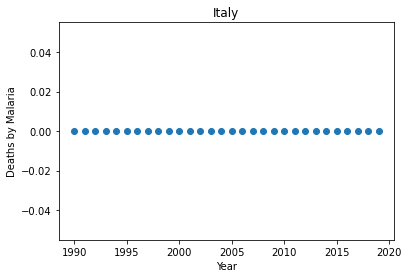

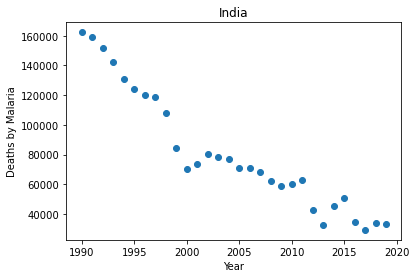

In [91]:
italy_specific = df[df.country=='Italy']
india_specific = df[df.country=='India']
# print(italy_specific)
plt.scatter(x=italy_specific.year, y=italy_specific['malaria'])
plt.title('Italy')
plt.xlabel('Year')
plt.ylabel('Deaths by Malaria')
plt.show()
plt.close()
plt.scatter(x=india_specific.year, y=india_specific.malaria)
plt.title('India')
plt.xlabel('Year')
plt.ylabel('Deaths by Malaria')
plt.show()
plt.close()

See if we can iterate through each country and disease and test if linear relationship over time.

In [96]:
countries_unique = df['country'].unique()

causes_of_death = list(df.columns[3:])[:-2]

# print(countries_unique)
def check_linearity(df, countries, causes):
    linear_rel_over_time = {}
    for country in countries:
        c_data = df[df.country == country]
        for cause in causes:
            cov = np.cov(c_data[cause], c_data.year)
            if cov[0][1] != 0:
                if country not in linear_rel_over_time:
                    linear_rel_over_time[country] = [cause, f"cov: {cov[0][1]}"]
                else:
                    linear_rel_over_time[country].append(cause)
                    linear_rel_over_time[country].append(f"cov: {cov[0][1]}")
            corr, p = pearsonr(c_data[cause], c_data.year)
            if (corr > 0.3 or corr < -0.3):
                linear_rel_over_time[country].append(f"corr: {corr}")
                linear_rel_over_time[country].append(f"p-value: {p}")
    return linear_rel_over_time
linearity = check_linearity(df, countries_unique, causes_of_death)
# print(linearity)

            

return a list or dataframe of max and min causes of death.

In [93]:
# def max_min(df):
maxes = df.malaria.max()
row = df[df.road_injuries == df.road_injuries.min()]
print(maxes)
print(row.country.unique())

280604.0
['Niue' 'Tokelau']


Create a map.

In [99]:
# create map object
my_map = folium.Map(
    location=[15.724580,14.487975],
    zoom_start=2
    ) 
# generate map
my_map.save('map.html')

There are more unique countries represented in our data set than exist. There are only 195 countries in the world and 204 represented in our data set. We'll need to look through the countries and make sure there are no typos or errors.

Check for null values in each column.